# The temperature of a Sunspot

The aim of this lab is to introduce the you to astronomical observations, and to walk you through the basic steps of doing scientific research where a sunspot will be studied and its temperature will be determined. 

We will focus on an observation of a sunspot taken on 2014-09-05 at 07:59. The sunspot is part of an active region called AR12152 and was observed with the Swedish 1-m Solar Telescope. 

This notebook will walk you through all the steps, leaving some parts blank for you to fill in. 

<img src="includes/sdo.png" width="600">



(235, 250)


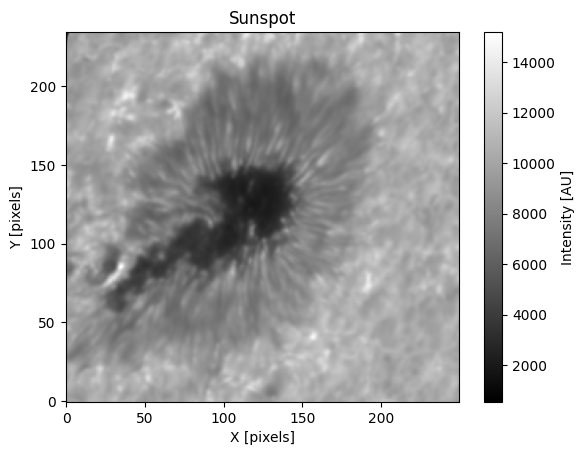

In [3]:
#Packages that we need
import matplotlib.pyplot as plt
import numpy as np

#We start by loading the sunspot data into the memory. 
imagedata = np.load('includes/spot.npy')

#You can get the shape of the data with the following command
print(imagedata.shape)

#Now we can take a look at the data by plotting it. 
plt.imshow(imagedata, origin='lower', cmap='gray')
plt.xlabel('X [pixels]')
plt.ylabel('Y [pixels]')
plt.title('Sunspot')
cb = plt.colorbar()
cb.set_label('Intensity [AU]')
plt.show()

## Calibration 1

Before we start studying this data, we have to calibrate it first. If we look at the image we can see that it has an X and Y direction, as well as a value for each pixel. 
The sunspot is dark, while its surrounding is brighter, but these numbers do not mean anything physical. 

First off, the X and Y directions have a resolution of 0.17 arcseconds per pixel. We can convert this into length units on the Sun by using Pythagoras. Imagine a triangle with a distance of 1 AU (1.5*10^5 Mm), with an angle of 0.17 arcseconds. What length does one pixel correspond to?

In [4]:
# First we convert the value in arcseconds to radians. 

theta_arcsec = 0.17 #arcseconds
d_sun = 1.5e5 #Mm

#<--START OWN CODE --> 
theta = theta_arcsec / 60 / 60 / 180 * np.pi 
#<-- END OWN CODE  -->

# Next we have to solve the triangle by using a tangent

#<--START OWN CODE --> 
X_Mm = np.tan(theta)*d_sun
#<-- END OWN CODE  -->

print('%s Mm/pixel or %s Km/pixel' % (np.round(X_Mm,3), np.round(X_Mm*1000)))

0.124 Mm/pixel or 124.0 Km/pixel


## Calibration 2

Now we can calibrate the values by checking what the intensity of a blackbody radiator would be at the observed wavelength of 6302 Å (or 630.2 nm).

We know that the planck function looks like,

$B_\nu (\nu,T) = \frac{2h\nu^3}{c^2}\frac{1}{exp(\frac{h\nu}{k_BT}-1)}$.

Now all that we need to do is create a function out of it. For that we will can use SI numbers, or the *astropy* units library.

In [5]:
#If we use the astropy units, then import these two packages.
from astropy import units as u
from astropy import constants as const

#Now fill in the function below including all constants. Don't forget to convert wavelengths to frequencies!
#Constants can be found using the astropy constants package imported above.

#<--START OWN CODE --> 
def planck(w,T):
    h = const.h
    c = const.c
    k = const.k_B
    nu = (const.c / (w * u.angstrom)).decompose()
    T = T * u.K
    
    B = ((2*h*nu**3)/c**2 * 1/(np.exp(((h*nu)/(k*T)) - 1))).decompose().value
    
    return B
#<-- END OWN CODE  -->



#now use the function to get a blackbody value at 6302 Å with a surface temperature of 5777 K. 

factor = planck(6302,5777)


print('%s W/sr/m^2/Hz' % factor)

8.291842173764805e-08 W/sr/m^2/Hz


## Apply calibration

Now that we have the units for x,y and the intensity we can apply them. The X,Y values is simply a question of rescaling the x and y axis numbers, but applying the intensity calibration is slightly harder. 

To do this we need to first select a piece of so-called quiet-Sun, or an area that does not have a sunspot in it. This area should then be averaged to find what number corresponds to quiet Sun in this image. We then normalize the image by this value so and multiply with the constant that we found in the last block. 

8678.915


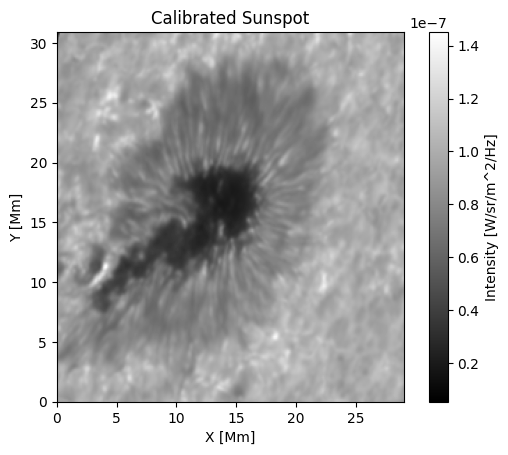

In [7]:
# Looking back at the data, we find a good area of quiet Sun to the right of the spot, beyond 200 pixels on the x-axis.
# Lets try to select that area, and print the average value.

#<--START OWN CODE -->
quiet_sun = np.mean(imagedata[:,:200])
#<-- END OWN CODE  -->

print(quiet_sun)

# now we divide this value out of the cube and apply the new factor. 

normalized_image = imagedata / quiet_sun
calibrated_image =  normalized_image * factor

# Now we plot a new image, and include the right scale.

plt.imshow(calibrated_image, origin='lower', cmap='gray', extent=[0,235*X_Mm, 0, 250*X_Mm])
plt.xlabel('X [Mm]')
plt.ylabel('Y [Mm]')
plt.title('Calibrated Sunspot')
cb = plt.colorbar()
cb.set_label('Intensity [W/sr/m^2/Hz]')
plt.show()


## Temperature inferement

Now that our data is calibrated we can start working on the temperature inferment. We will get this by once more using the planck function, but this time in reverse. We know the wavelength, and the intensity ($B_\nu$), so we need to rewrite the equation in such a way that it outputs temperature. 

We can test if it works by plugging in 'factor', as that should give back 5777 K by definition.

In [8]:
#import units if needed
from astropy import units as u
from astropy import constants as const

#<--START OWN CODE -->
def btemp(B):
    #temperature from inverse Planck function
    
    h = const.h
    c = const.c
    nu = (c / (6302 * u.angstrom)).decompose()
    k = const.k_B
    B = B * u.W / u.m**2 / u.Hz 
      
    T = ( (h * nu) / (k * ( np.log( (2 * h * nu**3) / ( B * c**2 ) ) + 1 ) ) ).decompose().value
        
    return T
#<-- END OWN CODE  -->

temp = btemp(factor)

print('%s K' % temp) 

5777.000000000001 K


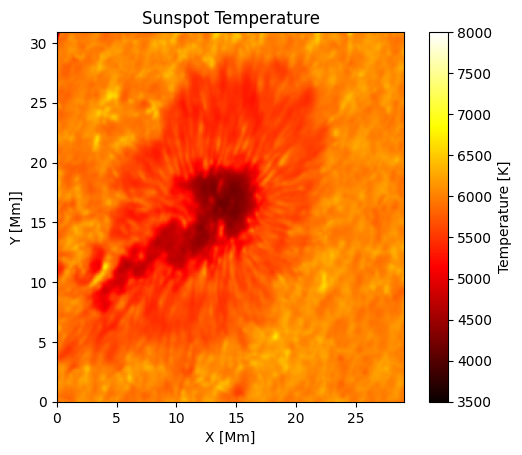

In [9]:
# Now that this is working, we can infer the temperature at any pixel. 
# In fact we can find the temperature of the entire image!

# Depending on how you built the function, you might be able to plug in the full image.
# Alternatively, you might have to loop over each pixel seperately.  

#<--START OWN CODE -->
temperature_image = btemp(calibrated_image)
#<-- END OWN CODE  -->

#Now plot the result

plt.imshow(temperature_image, origin='lower', cmap='hot', extent=[0,235*X_Mm, 0, 250*X_Mm], vmax=8000, vmin=3500)
plt.xlabel('X [Mm]')
plt.ylabel('Y [Mm]]')
plt.title('Sunspot Temperature')
cb = plt.colorbar()
cb.set_label('Temperature [K]')
plt.show()


## Average temperatures

From the image above we can see that a sunspot is around 4000 K. The penumbra is hotter at around 5000 K, and the quiet Sun is around 6000 K with some hotter and colder spots. 

However, this is awfully unspecific for how far we have gotten, so we should try to get the average temperature of all 3 regions. This is reasonably easy to do by applying a mask that seprates the three regions based on intensity. 

We do this by creating an intensity threshold that selects pixels belonging to the three regions. 

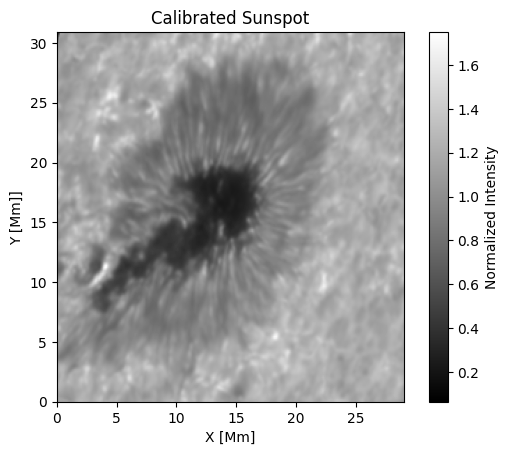

In [10]:
# We start by using the normalized cube, which has a value of 1 for the quiet Sun and something lower for the spots. 

plt.imshow(normalized_image, origin='lower', cmap='gray', extent=[0,235*X_Mm, 0, 250*X_Mm])
plt.xlabel('X [Mm]')
plt.ylabel('Y [Mm]]')
plt.title('Calibrated Sunspot')
cb = plt.colorbar()
cb.set_label('Normalized Intensity')
plt.show()

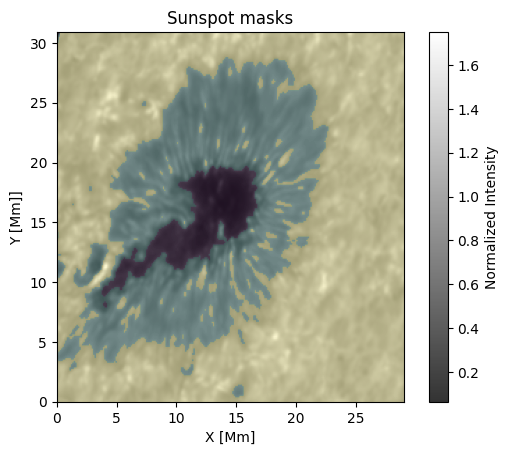

In [11]:
# Now we try to find a number that seperates the sunspot umbra, penumbra and quiet Sun. 
# This is done by defining a maximal and minimal intensity for the penumbra. 
# Evererything above the maximal penumbra value is quiet Sun, everything that is below the minimum is umbra. 

#<--START OWN CODE -->
max_penumbra = 0.99
min_penumbra = 0.55
#<-- END OWN CODE  -->

# Now we make 3 masks based on these values.

mask_qs = np.where(normalized_image > max_penumbra)
mask_pu = np.where((normalized_image > min_penumbra) & (normalized_image < max_penumbra))
mask_um = np.where(normalized_image < min_penumbra)

# We create a new image that has one value for each of the three masks.
mask = np.zeros_like(normalized_image)
mask[mask_qs] = 2
mask[mask_pu] = 1
mask[mask_um] = 0

# Finally we plot the mask over the image to see how well we are doing. 

plt.imshow(mask, origin='lower',  extent=[0,235*X_Mm, 0, 250*X_Mm])
plt.imshow(normalized_image, origin='lower', cmap='gray', extent=[0,235*X_Mm, 0, 250*X_Mm], alpha=0.8)
plt.xlabel('X [Mm]')
plt.ylabel('Y [Mm]]')
plt.title('Sunspot masks')
cb = plt.colorbar()
cb.set_label('Normalized Intensity')
plt.show()

In [12]:
# Now we measure the average temperature of each of these three regions. 

#<--START OWN CODE -->
t_qs = np.mean(temperature_image[mask_qs])
t_pu = np.mean(temperature_image[mask_pu])
t_um = np.mean(temperature_image[mask_um])
#<-- END OWN CODE  -->

print('The average quiet Sun temperature is %s K.' % t_qs) 
print('The average penumbral temperature is %s K.' % t_pu)
print('The average umbral temperature    is %s K.' % t_um)

The average quiet Sun temperature is 6028.994 K.
The average penumbral temperature is 5542.6226 K.
The average umbral temperature    is 4645.936 K.


## Repeat the excersize using spectra

Now that we have found the average temperatures of the quiet Sun, umbra and penumbra we can compare the results to another data set. In this case observations made with the Heliostat on top of Stockholm University's Albanova building. Here we use an observations taken on 2023-01-18, of AR13190. 

Unlike with the last data set, we now use a spectrograph which does not take images but spectra. For this reason the data reduction and calibration works a bit different, but the final idea is the same.

<img src="includes/sdo2.png" width="600">

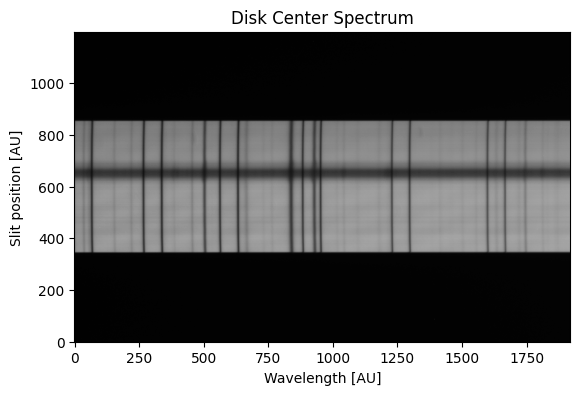

In [18]:
# The data here is different than the image that was studied before. 
# Here the data shows wavelength over the x-axis and position along the y-axis. 
# The best way to imagine it is that every pixel on the y axis is 'unpacked' into a full spectrum.
# We can see that when we load the data and compare what we see to where the red line is situated in the image above.

# We can take a look at the data by using the following package
from includes.read_pgm import read_pgm as rpgm
spectrum = rpgm('includes/15452646-2023-01-18-122212.pgm')

#Show the data
plt.imshow(spectrum, origin='lower', cmap='gray')
plt.xlabel('Wavelength [AU]')
plt.ylabel('Slit position [AU]')
plt.title('Disk Center Spectrum')
plt.show()

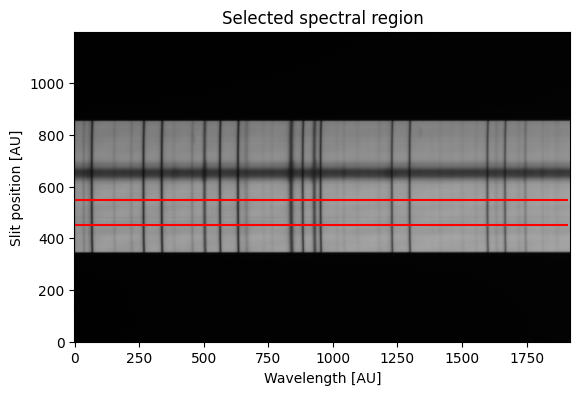

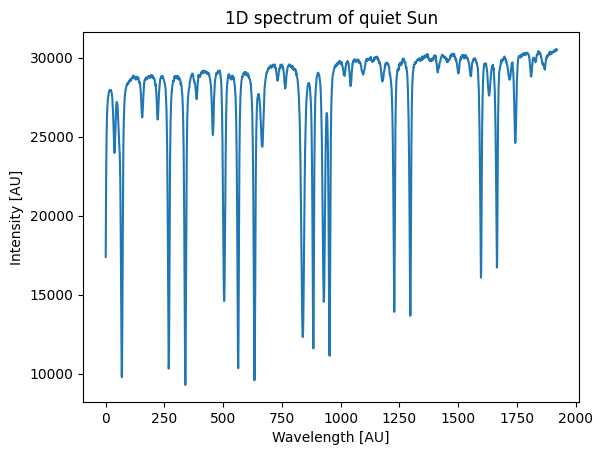

In [19]:
# Here we see that in the x direction there are spectral lines, which are darker than the continuum. 
# However in the y direction we are looking at the spacial direction, we see the sunspot 1/3rd down as a dark band.

# Like in the last excersise we have to first calibrate the quiet Sun before we can focus on the spot. 
# For this reason we pick a y-range that is not dark, and not covered by the spot.

# Pick two coordinates: 

#<--START OWN CODE --> 
y1 = 450 
y2 = 550 
#<-- END OWN CODE  -->

#Show the area over which we average with 2 red lines
plt.imshow(spectrum, origin='lower', cmap='gray')
plt.hlines([y1,y2],0,1910,color='red')
plt.xlabel('Wavelength [AU]')
plt.ylabel('Slit position [AU]')
plt.title('Selected spectral region')
plt.show()

#We then slice the 2d spectrum and take the median of the values slected to remove outliers. 
spectrum1d = np.median(spectrum[y1:y2], axis=0)

#We then plot the resulting 1D spectrum 
plt.figure()
plt.plot(spectrum1d)
plt.ylabel('Intensity [AU]')
plt.xlabel('Wavelength [AU]')
plt.title('1D spectrum of quiet Sun')
plt.show()

## Wavelength calibration

We start by creating an absolute wavelength axis to match the data. This is done by using the two narrow lines in the image above. These so-called teluric lines are caused by the atmosphere of the Earth, and are not related to anything happening on the Sun. This means that they are very stable in wavelength, and can be used to find the pixel scale of the instrument. 

The two lines are located at 6302.000 Å and 6302.764 Å respectivelly. 


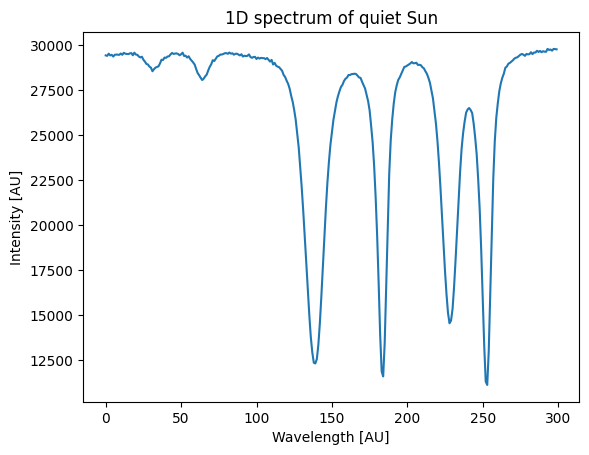

In [20]:
# There is a pair of well known iron lines around x = 1000 which include the same wavelength that we studied before.
# We are interested in the four lines between x = 700 and 1000.

# Select the correct values.

#<-- START OWN CODE  -->
x1 = 700   
x2 = 1000  
#<-- END OWN CODE  -->

# we cut the spectrum
spec = spectrum1d[x1:x2]

# We then plot the spectrum again and see our lines and the continuum.
plt.figure()
plt.plot(spec)
plt.ylabel('Intensity [AU]')
plt.xlabel('Wavelength [AU]')
plt.title('1D spectrum of quiet Sun')
plt.show()


Telurics are located at x = 184 and x = 253.
Distance between telurics is 69 pixels.
Distance between telurics is 0.7640000000001237 Angstrom.
Resolution is 0.011072463768117735 Angstrom/pixel.


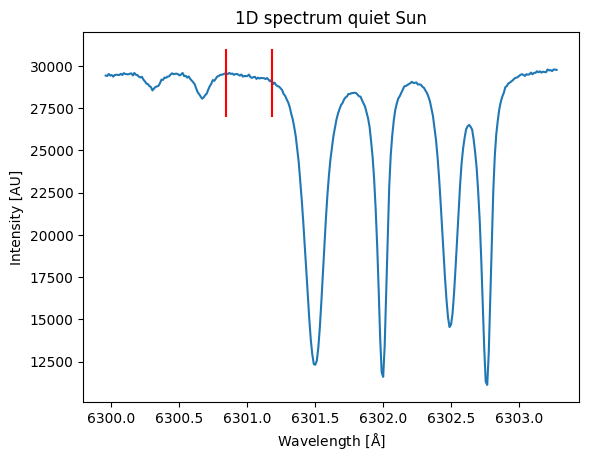

In [21]:
# The telluric lines (spectral lines with origin in the Earth's atmosphere) can be found around x=180 and x=250. 
# First we need to find a way to find their midpoints. This can be done with a code to find the minimum, 
# or you can just zoom in on the image until you find the right pixel within 1 decimal.


# The x position of the two telluric lines respective postion in the cut image is:

#<-- START OWN CODE  -->
t2 = np.where(spec == np.min(spec))[0][0]
t1 = np.where(spec == np.min(spec[:-100]))[0][0]
#<-- END OWN CODE  -->

print('Telurics are located at x = %s and x = %s.' % (t1,t2))

# This means that the distance in pixels is
#<-- START OWN CODE  -->
dt = t2-t1 
#<-- END OWN CODE  -->
print('Distance between telurics is %d pixels.' % dt)

# Now we repeat this with the measured wavelengths of the lines which are given to be
tw1 = 6302.000
tw2 = 6302.764

# This means that the distance in angstrom is 
#<-- START OWN CODE  -->
dtw = tw2-tw1
#<-- END OWN CODE  -->
print('Distance between telurics is %s Angstrom.' % dtw)

# Find the correct Angstrom/pixel value from these two values
#<-- START OWN CODE  -->
pa = dtw/dt 
#<-- END OWN CODE  -->
print('Resolution is %s Angstrom/pixel.' % pa)

# We know how many pixels there are before and after the first teluric line
# Thus we can make a wavelength array for this part of the spectrum
# We do this by making an increasing array (e.g. np.arange) of the same length as the spectrum and then multiply it 
# with our pixel scale and add the wavelength of the first pixel

#<-- START OWN CODE  -->
wav = np.arange(len(spec))*pa + tw1-(t1)*pa 
#<-- END OWN CODE  -->

#We can now use that to plot the spectrum with real wavelengths 
#We then plot the spectrum again. 
plt.figure()
plt.plot(wav,spec)
plt.ylabel('Intensity [AU]')
plt.xlabel(r'Wavelength [$\mathrm{\AA}$]')
plt.title('1D spectrum quiet Sun')
plt.vlines([wav[80],wav[110]],31000,27000,color='red')
plt.show()


## Further calibrations 

Now that we have a wavelength scale, we can either do the same as before and calibrate the continuum to a black body, or do a more acurate calibration by fitting the spectrum to the solar atlas. The latter is a very acurately calibrated spectrum of the Sun where the intensity of the quiet Sun is known at each wavelength.  

$\lambda$ is between 6300.848463768116 and 6301.180637681159, mean is 6301.014550724638


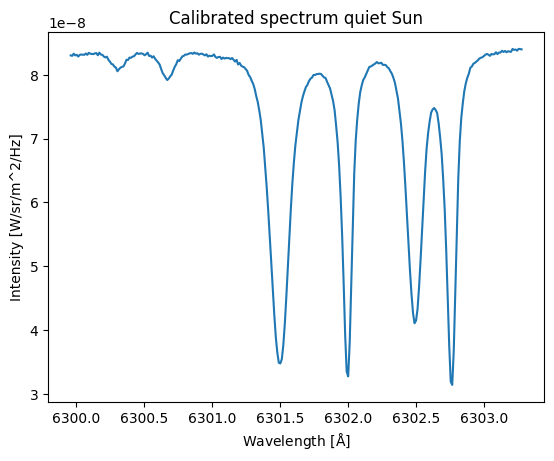

In [22]:
#Option 1: calibrate using the solar atlas 
#import ISPy

# To calibrate using the atlas use the following function
#wave_cal, spec_cal, factor, spec_fts, units = calib.spectrum(wav, spec, calib_wave=True, wave_idx=[np.arange(len(spec))], verbose=True)

#End of option 1

#Option 2: calibrate the continuum to a black body
# Let's calibrate it using te planck function as we did for the prior image. 
# We first select a piece of continuum between x = 80 and 110, which corresponds to a wavelength of; 
#<-- START OWN CODE  -->
w1 = wav[80]
w2 = wav[110]
#<-- END OWN CODE  -->
w3 = np.mean([w1,w2])

#We define the temperature again
T = 5777 #K
print(r'$\lambda$ is between %s and %s, mean is %s' % (w1,w2, w3))

factor = planck(w3,T)

# Now we divide the mean intensity in counts out of the spectrum and multiply by the factor.
#<-- START OWN CODE  -->
meanint = np.mean(spec[80:110])
spec_cal = spec / meanint * factor # ??
#<-- END OWN CODE  -->

#End of option 2

plt.figure()
plt.plot(wav,spec_cal)
plt.ylabel('Intensity [W/sr/m^2/Hz]')
plt.xlabel(r'Wavelength [$\mathrm{\AA}$]')
plt.title('Calibrated spectrum quiet Sun')
plt.show()



## Applying the calibration

We can now apply the calibration to the entire spectrum, including the sunspot. Which will allow us to retrieve its temperature.  

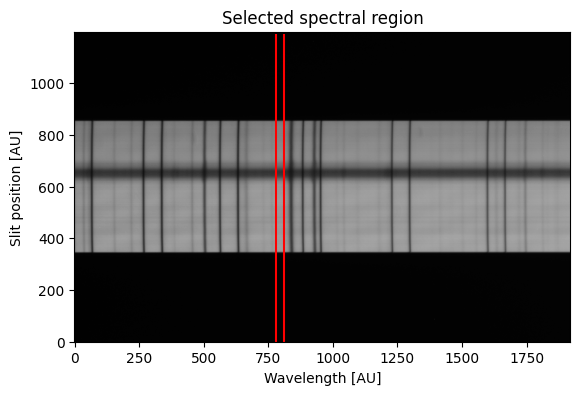

(1200, 1920)


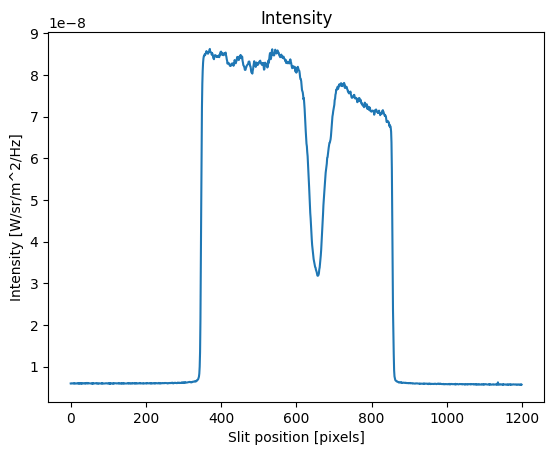

In [23]:
# Apply the same calibration to the full spectrum 
#<-- START OWN CODE  -->
spectrum_calibrated = spectrum / meanint * factor 
#<-- END OWN CODE  -->

# We can now make a vertical cut through the spectrum at the same location of the continuum and plot that. 
# Do not forget to take the average!

#Show the area over which we average with 2 red lines
plt.imshow(spectrum, origin='lower', cmap='gray')
plt.vlines([x1+80,x1+110],0,1190,color='red')
plt.xlabel('Wavelength [AU]')
plt.ylabel('Slit position [AU]')
plt.title('Selected spectral region')
plt.show()

#<-- START OWN CODE  -->
avg_int_6301 = np.mean(spectrum_calibrated[:,x1+80:x1+110], axis=1)
#<-- END OWN CODE  -->
print(spectrum_calibrated.shape)

# We now plot the resulting cut. 
 
plt.figure()
plt.plot(avg_int_6301)
plt.ylabel('Intensity [W/sr/m^2/Hz]')
plt.xlabel('Slit position [pixels]')
plt.title('Intensity')

plt.show()


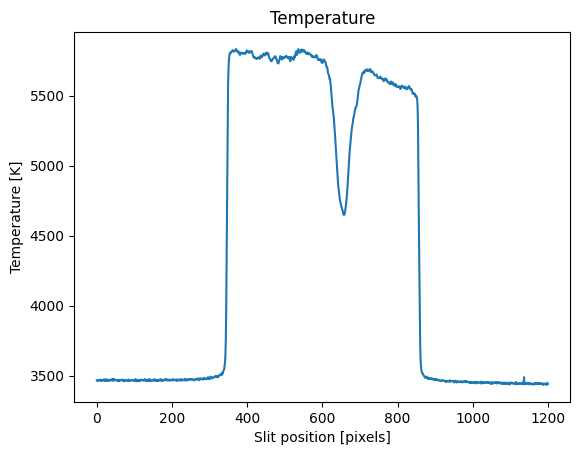

Sunspot temperature is 4649.000177339634 K


In [24]:
# We can plug this into our temperature function to get the temperature.
spec_temp = btemp(avg_int_6301)

plt.figure()
plt.plot(spec_temp)
plt.ylabel('Temperature [K]')
plt.xlabel('Slit position [pixels]')
plt.title('Temperature')

plt.show()

# We find the sunspot temperature by taking the minimum value of the array between x=400 and 800.
#<-- START OWN CODE  -->
sunspot_temp = np.min(spec_temp[400:800])
#<-- END OWN CODE  -->

print('Sunspot temperature is %s K' % sunspot_temp)

## Conclusions

Unlike in the last data set, it is difficult to define where the sunspot umbra ends and the penumbra begins. Additionally, we can see that the continuum intensity, and thus temperature are not constant. The slope is likely a signature of limb darkening, while the flatter part might be the result of a bright plage that negates this effect. It is important to be aware of these effects and disuss them, as they will effect the uncertainly in your result. 